## Flight data pytorch LSTM example

[flight-passengers-prediction-LSTM/flight\_passengers\_prediction\_LSTM.ipynb at master · mikel-brostrom/flight-passengers-prediction-LSTM](https://github.com/mikel-brostrom/flight-passengers-prediction-LSTM/blob/master/flight_passengers_prediction_LSTM.ipynb)

not used but same dataset:

[LSTM for Time Series Prediction in PyTorch - MachineLearningMastery.com](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2025-02-13 23:49:59--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2025-02-13 23:49:59 (30.6 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

### View data

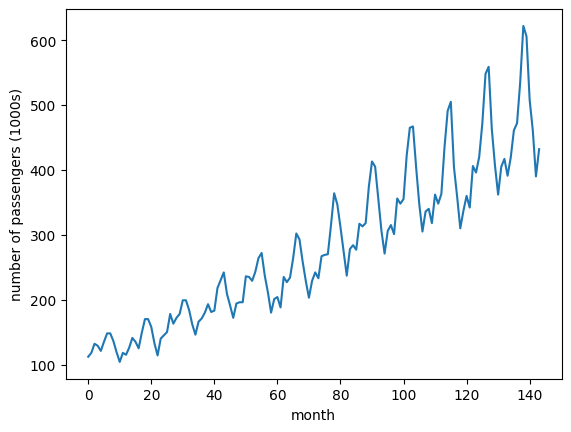

In [6]:
training_set = pd.read_csv('airline-passengers.csv')

training_set = training_set.iloc[:,1:2].values

plt.xlabel('month')
plt.ylabel('number of passengers (1000s)')
plt.plot(training_set)
plt.show()

### Generate test and train data

In [23]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.60)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print(training_data.shape)
print(dataX.shape)
print(dataY.shape)
print(trainX.shape)
print(trainY.shape)

(144, 1)
torch.Size([139, 4, 1])
torch.Size([139, 1])
torch.Size([83, 4, 1])
torch.Size([83, 1])


In [24]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [25]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 50
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06341
Epoch: 100, loss: 0.00216
Epoch: 200, loss: 0.00151
Epoch: 300, loss: 0.00148
Epoch: 400, loss: 0.00146
Epoch: 500, loss: 0.00157
Epoch: 600, loss: 0.00131
Epoch: 700, loss: 0.00104
Epoch: 800, loss: 0.00093
Epoch: 900, loss: 0.00083
Epoch: 1000, loss: 0.00077
Epoch: 1100, loss: 0.00082
Epoch: 1200, loss: 0.00070
Epoch: 1300, loss: 0.00072
Epoch: 1400, loss: 0.00045
Epoch: 1500, loss: 0.00040
Epoch: 1600, loss: 0.00034
Epoch: 1700, loss: 0.00032
Epoch: 1800, loss: 0.00030
Epoch: 1900, loss: 0.00026


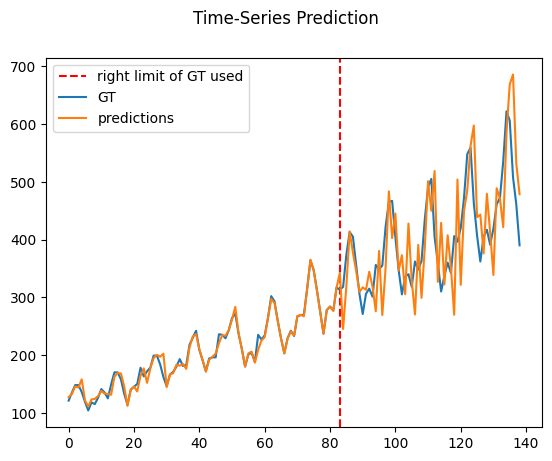

In [26]:
lstm.eval()

# predict on training and test data
all_predict = lstm(dataX)

data_predict = all_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of GT used')

plt.plot(dataY_plot, label='GT')
plt.plot(data_predict, label='predictions')
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()